# Simulate Time Crystal

**Author:** Chenning Tao

**Date:** 13/4/2024

Based on paper "[Digital quantum simulation of Floquet symmetry-protected topological phases][1]"

[1]: https://www.nature.com/articles/s41586-022-04854-3


In this part, we will demonstrate how to simulate topology time crystal using Qiskit on our cloud platform and compare the simulated result with the real experiment result.

## Build circuit function for FSPT phase

The circuit if based on the this time-periodic Hamiltonian transformation:
$$\begin{gathered}
H(t)= \begin{cases}H_1, & \text { for } 0 \leq t<T^{\prime}, \\
H_2, & \text { for } T^{\prime} \leq t<T,\end{cases} \\
H_1 \equiv\left(\frac{\pi}{2}-\delta\right) \sum_k \hat{\sigma}_k^x, \\
H_2 \equiv-\sum_k\left[J_k \hat{\sigma}_{k-1}^z \hat{\sigma}_k^x \hat{\sigma}_{k+1}^z+V_k \hat{\sigma}_k^x \hat{\sigma}_{k+1}^x+h_k \hat{\sigma}_k^x\right]
\end{gathered}$$

And the correspond circuit is shown in the figure.

<div style="text-align:center;">
    <img src="./pictures/4-2.circuit.png"  width="50%" height="50%">
</div>

The $H_1$ corresponds to the circuit in green background.

In [1]:
# import necessary dependencies
import qiskit
import numpy as np
from qiskit import *

# define the number of qubits, in this tutorial we use 8 qubits
num_qubits = 8

# construct the quantum circuit corrsponding to H1
def H1_FSPT(qc):
    # apply RX gates to all qubits with angle 0.99*pi
    for j in range(num_qubits):
        qc.rx(np.pi * 0.99, j)
    return qc

qc = QuantumCircuit(num_qubits)
print(H1_FSPT(qc))

     ┌────────────┐
q_0: ┤ Rx(3.1102) ├
     ├────────────┤
q_1: ┤ Rx(3.1102) ├
     ├────────────┤
q_2: ┤ Rx(3.1102) ├
     ├────────────┤
q_3: ┤ Rx(3.1102) ├
     ├────────────┤
q_4: ┤ Rx(3.1102) ├
     ├────────────┤
q_5: ┤ Rx(3.1102) ├
     ├────────────┤
q_6: ┤ Rx(3.1102) ├
     ├────────────┤
q_7: ┤ Rx(3.1102) ├
     └────────────┘


The $H_2$ corresponds to the circuit in yellow background. For the parameter of RY (Jk), we use randomly generated value from uniform distribution.

In [21]:
# construct the quantum circuit corrsponding to H2
from scipy.stats import uniform
def H2_FSPT(qc):
    # apply CRZ, the control qubit is odd, the target qubit is even, angle is pi
    for j in range(1, num_qubits, 2):
        qc.crz(np.pi, j-1, j)
    # apply CRZ
    for j in range(2, num_qubits, 2):
        qc.crz(np.pi, j-1, j)

    # apply RY
    # generate the parameter from uniform distribution
    rand_values = uniform.rvs(-4, 4, size=num_qubits-2)
    for j in range(1, num_qubits-1):
        qc.ry(-2*(1 + rand_values[j-1]), j)

    # apply CRZ
    for j in range(2, num_qubits, 2):
        qc.crz(-np.pi, j-1, j)

    for j in range(1, num_qubits, 2):
        qc.crz(-np.pi, j-1, j)

    return qc

# show the quantum circuit
qc = QuantumCircuit(num_qubits)
print(H2_FSPT(qc))

                                                          
q_0: ────■──────────────────────────────────────────■─────
     ┌───┴───┐          ┌────────────┐          ┌───┴────┐
q_1: ┤ Rz(π) ├────■─────┤ Ry(1.9953) ├────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐ ├────────────┤┌───┴────┐└────────┘
q_2: ────■────┤ Rz(π) ├─┤ Ry(1.9976) ├┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘┌┴────────────┤└────────┘┌───┴────┐
q_3: ┤ Rz(π) ├────■────┤ Ry(0.65881) ├────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐├─────────────┤┌───┴────┐└────────┘
q_4: ────■────┤ Rz(π) ├┤ Ry(-1.9142) ├┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘└┬────────────┤└────────┘┌───┴────┐
q_5: ┤ Rz(π) ├────■─────┤ Ry(5.2618) ├────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐ ├────────────┤┌───┴────┐└────────┘
q_6: ────■────┤ Rz(π) ├─┤ Ry(4.4142) ├┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘ └────────────┘└────────┘┌───┴────┐
q_7: ┤ Rz(π) ├──────────────────────────────────┤ Rz(-π) ├
     └───────┘                                  └───────

# Build the circuit

We build the circuit using the above function according to the time step and add some initialization and measurement for the circuit.

In [58]:
def build_circuit(n):
    qc = QuantumCircuit(num_qubits)

    reversed = []
    # initialize the quantum state random orthogonal state of |0> and |1>
    for i in range(0, num_qubits):
        if np.random.rand() > 0.5:
            qc.x(i)
            reversed.append(num_qubits-i-1)

    # build circuit
    for i in range(1, n+1):
        # if is odd
        if i % 2 == 1:
            qc = H1_FSPT(qc)
        else:
            qc = H2_FSPT(qc)

    qc.measure_all()
    return qc, reversed


# Simulating

For each duration of time step, we caculate the expection based on the measurement result.

$$\overline{\left\langle\sigma_j^z(t)\right\rangle} = p_0 - p_1 = 1 - 2\times p_1$$

In [59]:
# run the quantum circuit
qc, reversed = build_circuit(1)
from qiskit import Aer, execute
backend = Aer.get_backend('qasm_simulator')
qc = transpile(qc, backend)
res = backend.run(qc, shots=100).result().get_counts()

# calculate the expectation value of the Z operator
def expectation_value(res, i, reversed):
    total_counts = sum(res.values())
    p1 = 0
    for bitstring, count in res.items():
        if bitstring[i] == '1':
            p1 += count / total_counts
    if i in reversed:
        return -(1-2*p1)
    return 1 - 2*p1

print(qc)
for i in range(8):
    print(i, expectation_value(res, i, reversed))

global phase: π/2
        ┌────────────────────┐ ░ ┌─┐                     
   q_0: ┤ U3(π/100,π/2,-π/2) ├─░─┤M├─────────────────────
        ├────────────────────┤ ░ └╥┘┌─┐                  
   q_1: ┤ U3(π/100,π/2,-π/2) ├─░──╫─┤M├──────────────────
        └───┬────────────┬───┘ ░  ║ └╥┘┌─┐               
   q_2: ────┤ Rx(3.1102) ├─────░──╫──╫─┤M├───────────────
            ├────────────┤     ░  ║  ║ └╥┘┌─┐            
   q_3: ────┤ Rx(3.1102) ├─────░──╫──╫──╫─┤M├────────────
            ├────────────┤     ░  ║  ║  ║ └╥┘┌─┐         
   q_4: ────┤ Rx(3.1102) ├─────░──╫──╫──╫──╫─┤M├─────────
            ├────────────┤     ░  ║  ║  ║  ║ └╥┘┌─┐      
   q_5: ────┤ Rx(3.1102) ├─────░──╫──╫──╫──╫──╫─┤M├──────
        ┌───┴────────────┴───┐ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_6: ┤ U3(π/100,π/2,-π/2) ├─░──╫──╫──╫──╫──╫──╫─┤M├───
        └───┬────────────┬───┘ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_7: ────┤ Rx(3.1102) ├─────░──╫──╫──╫──╫──╫──╫──╫─┤M├
            └────────────┘     ░  ║  ║  ║  ║  ║  ║  ║ 

# Draw the result

We can compare our result with the experiment result. For each point in the figure, we generate and run teh circuit for 100 times (ATTENTION: this could take a while!).

<div style="text-align:center;">
    <img src="./pictures/4-2.result.png"  width="50%" height="50%">
</div>

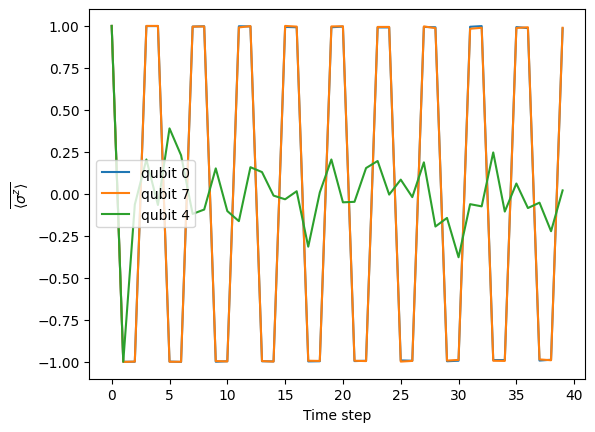

In [61]:
import matplotlib.pyplot as plt

res = []

# collect the result for time step from 1 to 40
for i in range(0, 40):
    # repeat 100 times
    res0 = 0
    res4 = 0
    res7 = 0
    repeat_time = 20
    for _ in range(repeat_time):
        qc, reversed = build_circuit(i)
        qc = transpile(qc, backend)
        result = backend.run(qc, shots=100).result().get_counts()
        res_0 = expectation_value(result, 0, reversed)
        res_4 = expectation_value(result, 4, reversed)
        res_7 = expectation_value(result, 7, reversed)
        res0 += res_0
        res4 += res_4
        res7 += res_7
    res0 /= repeat_time
    res4 /= repeat_time
    res7 /= repeat_time
    res.append([res0, res7, res4])

# plot the result
plt.plot(res)
plt.xlabel('Time step')
plt.ylabel(r'$\overline{\left\langle\sigma^z\right\rangle}$')
plt.legend(['qubit 0', 'qubit 7', 'qubit 4'])
plt.show()

The result will look like this:

<div style="text-align:center;">
    <img src="./pictures/4-2.result_sim.png"  width="50%" height="50%">
</div>